In [85]:
import os
import pandas as pd
import datetime
import empyrical as empy

In [86]:
tradedates = pd.read_csv('./data/date_features.csv', index_col=0)
tradedates.index = pd.to_datetime(tradedates.index).date
tradedates = tradedates.index

In [87]:
excel_info = pd.read_excel('./data/Book1.xlsx', sheet_name=['Sheet1', 'Sheet5', 'Sheet6'], index_col=0)
excel_info.keys()


dict_keys(['Sheet1', 'Sheet5', 'Sheet6'])

In [89]:
init = pd.DataFrame(1e+09, index=['2007-12-31'], columns=['agg', 'mod', 'con', 'ficon'])
# # init = init.to_frame().T
# # init
# sim_bal = pd.concat([init, sim_bal])
# sim_bal

In [90]:
sim_bal = excel_info['Sheet1']
sim_bal = pd.concat([init, sim_bal])
sim_bal.index = pd.to_datetime(sim_bal.index).date

nonShort_bal = excel_info['Sheet5']
nonShort_bal.index = pd.to_datetime(nonShort_bal.index, format='%Y%m%d').date
nonShort_bal.columns = [col.split(' ')[0] for col in nonShort_bal.columns]
short_bal = excel_info['Sheet6']
short_bal.index = pd.to_datetime(short_bal.index, format='%Y%m%d').date
short_bal.columns = [col.split(' ')[0] for col in short_bal.columns]

In [91]:
datelist = tradedates[tradedates>=sim_bal.index[0]]
datelist = datelist[datelist<=sim_bal.index[-1]]

sim_ret = sim_bal.loc[datelist, :].pct_change().dropna(how='all')
# nonShort_ret = nonShort_bal.pct_change().dropna(how='all')
# short_ret = short_bal.pct_change().dropna(how='all')

datelist = tradedates[tradedates>=nonShort_bal.index[0]]
datelist = datelist[datelist<=nonShort_bal.index[-1]]
nonShort_ret = (nonShort_bal.loc[datelist, :]/100).dropna(how='all')

datelist = tradedates[tradedates>=short_bal.index[0]]
datelist = datelist[datelist<=short_bal.index[-1]]
short_ret = (short_bal.loc[datelist, :]/100).dropna(how='all')

In [92]:
sim_ret

,agg,mod,con,ficon
2008-01-02,0.022231,0.013971,0.007571,0.010039
2008-01-03,0.004554,0.003102,0.001402,0.001893
2008-01-04,-0.004020,-0.007122,-0.001830,-0.003281
2008-01-07,-0.003225,-0.004153,-0.000975,-0.002144
2008-01-08,0.004124,0.003381,0.000978,0.002039
...,...,...,...,...
2021-12-27,0.013560,0.009009,0.004062,0.006371
2021-12-28,-0.001655,-0.001103,-0.001195,-0.001878
2021-12-29,-0.001164,-0.000774,-0.000389,-0.000624
2021-12-30,0.005597,0.003724,0.001674,0.002642


In [93]:
mm = {
    'agg': [datetime.date(2020, 12, 31), datetime.date(2021, 11, 30)],
    'mod': [datetime.date(2020, 1, 31), datetime.date(2021, 11, 30)], 
    'con': [datetime.date(2020, 1, 31), datetime.date(2022, 3, 31)], 
    'ficon': [datetime.date(2020, 12, 31), datetime.date(2021, 11, 30)]
}

In [94]:
clients = ['agg', 'mod', 'con', 'ficon']
ret = pd.DataFrame(columns=clients)
cum_return = pd.DataFrame(columns=clients)
for client in clients:
    date1 = mm[client][0]
    date2 = mm[client][1]

    ret1 = sim_ret.loc[sim_ret.index<=date1, client]
    ret2 = nonShort_ret.loc[(nonShort_ret.index>date1) & (nonShort_ret.index<=date2), client]
    # ret2 = ret2.loc[ret2.index<=date2]
    ret3 = short_ret.loc[(short_ret.index>date2), client]
    tmp = pd.concat([ret1, ret2, ret3])
    
    # datelist = tradedates[tradedates>=tmp.index[0]]
    # datelist = datelist[datelist<=tmp.index[-1]]

    # tmp = tmp[datelist]
    ret[client] = tmp
    cum_return[client] = empy.cum_returns(tmp)
    

<AxesSubplot:>

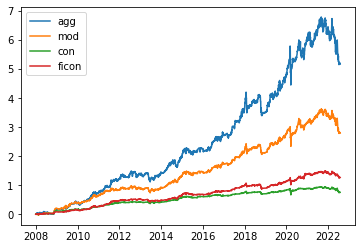

In [95]:
cum_return.plot()

In [96]:
res = pd.DataFrame(columns=ret.columns)
for col in ret.columns:
    res.loc['RETURN', col] = empy.annual_return(ret[col])
    res.loc['Volatility', col] = empy.annual_volatility(ret[col])
    res.loc['SHARPE RATIO', col] = empy.sharpe_ratio(ret[col])
    res.loc['Max-DD', col] = empy.max_drawdown(ret[col])
    res.loc['STD', col] = ret[col].std()
    res.loc['Total Return', col] = empy.cum_returns(ret[col]).values[-1]
    res.loc['worst return', col] = min(ret[col])
res

,agg,mod,con,ficon
RETURN,0.133042,0.095961,0.039575,0.057995
Volatility,0.123521,0.092436,0.047134,0.056132
SHARPE RATIO,1.073362,1.037776,0.84709,1.032553
Max-DD,-0.209459,-0.180934,-0.114088,-0.108716
STD,0.007781,0.005823,0.002969,0.003536
Total Return,5.166117,2.797999,0.759859,1.272819
worst return,-0.052369,-0.049222,-0.032691,-0.02868


In [97]:
month_shortname = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_return = pd.DataFrame()
YTD_reutrn = pd.DataFrame()
period_return_dict = {}
for col in ret.columns:
    monthly_return[col] = empy.aggregate_returns(ret[col], convert_to='monthly')
    YTD_reutrn[col] = empy.aggregate_returns(ret[col], convert_to='yearly')
    
    period_return =  monthly_return[col]
    period_return.index.names = ['year', 'month']
    period_return = period_return.reset_index(drop=False)
    period_return = period_return.pivot(index='year', columns='month', values=col)
    period_return = pd.concat([period_return, YTD_reutrn[col]], axis=1)
    period_return.columns = month_shortname + ['YTD']
    period_return = period_return.sort_index(ascending=False)
    period_return_dict[col] = period_return

In [101]:
for client, df in period_return_dict.items():
    display(client)
    display(df)

'agg'

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,YTD
2022,-0.036825,0.020753,0.004615,-0.051446,-0.020593,-0.082572,-0.013158,NaN,NaN,NaN,NaN,NaN,-0.169250
2021,-0.017822,-0.010886,-0.016143,0.029391,0.029840,0.011826,0.051219,0.009184,-0.059121,0.037002,-0.034261,0.019919,0.045264
2020,0.049970,0.034840,-0.041885,0.046795,0.009273,0.017573,0.068676,-0.010857,-0.030872,-0.043190,0.076595,0.044271,0.233335
2019,0.055241,0.002241,0.079278,0.000885,-0.011633,0.013618,-0.007395,0.081751,-0.017208,0.012923,0.022434,0.022159,0.278584
2018,0.076517,-0.072694,0.028356,-0.001377,0.018478,-0.000035,-0.001193,0.048464,-0.007387,-0.113765,0.002658,0.004464,-0.031327
2017,0.009295,0.010042,-0.015380,0.009626,0.068131,-0.001368,0.048256,0.002033,-0.011231,0.059577,0.017267,0.036375,0.254138
2016,-0.021190,0.004064,0.028208,-0.014418,0.022731,0.053729,0.031622,-0.001910,0.019505,-0.018062,0.013163,0.014863,0.137561
2015,0.089660,0.001099,-0.009449,-0.019256,-0.001483,-0.017551,0.028983,-0.009507,0.008339,0.035077,-0.002356,-0.004795,0.097975
2014,-0.014004,0.023968,0.020684,0.039221,0.047942,0.016911,-0.021226,0.047003,-0.072193,0.058774,0.045309,0.005890,0.208001
2013,-0.025914,-0.005374,0.031860,0.007213,-0.085229,-0.023154,0.042727,-0.030095,0.056254,0.011001,0.018029,0.031559,0.020499


'mod'

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,YTD
2022,-0.029548,0.013219,-0.000501,-0.042181,-0.000045,-0.086038,-0.011953,NaN,NaN,NaN,NaN,NaN,-0.149979
2021,-0.006771,0.004905,0.000226,0.024288,0.021191,0.006738,0.037570,0.007862,-0.037490,0.031749,-0.033177,0.012961,0.069192
2020,0.033716,-0.007930,-0.039039,0.021894,0.009298,0.025626,0.074018,-0.004932,-0.032922,-0.038146,0.047258,0.023632,0.110953
2019,0.036800,0.012405,0.053124,0.001039,-0.007747,0.009126,-0.004610,0.053842,-0.011023,0.009221,0.015933,0.022284,0.204831
2018,0.049997,-0.046844,0.019750,-0.000728,0.013535,-0.000754,-0.000615,0.032207,-0.006045,-0.078252,0.001844,0.003094,-0.019019
2017,0.006520,0.006705,-0.009676,0.006496,0.045773,-0.001446,0.032531,0.001419,-0.007301,0.040181,0.011959,0.024670,0.167655
2016,-0.013051,0.003842,0.026082,-0.010001,0.015150,0.036004,0.021363,-0.007836,0.017436,-0.012254,0.012807,0.011405,0.104172
2015,0.060191,0.002962,-0.006510,-0.014342,0.000383,-0.019600,0.028603,-0.006247,-0.003837,0.034783,-0.004432,-0.003156,0.067904
2014,-0.010887,0.016410,0.013986,0.026588,0.030783,0.013191,-0.012721,0.055973,-0.038706,0.051396,0.030572,0.004927,0.192695
2013,-0.015084,-0.003199,0.021534,0.004947,-0.056412,-0.014032,0.042730,-0.027113,0.022668,0.008907,0.014942,0.024147,0.020170


'con'

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,YTD
2022,-0.017431,0.002488,0.004334,-0.019326,0.004444,-0.049775,-0.009623,NaN,NaN,NaN,NaN,NaN,-0.082938
2021,-0.004770,-0.005500,-0.004894,0.019268,0.009235,0.002218,0.008979,-0.000293,-0.020967,0.014947,-0.011151,0.005335,0.011758
2020,0.010083,-0.009028,-0.023323,0.015773,0.004368,0.013782,0.022790,0.000315,-0.004222,-0.007024,0.005120,0.006482,0.034790
2019,0.012210,-0.002598,0.017983,0.006159,-0.001854,0.003975,-0.001829,0.021299,-0.006037,0.005099,0.009221,0.006873,0.072416
2018,0.017689,-0.024428,0.006840,-0.000365,0.005834,-0.000836,0.002575,0.006828,0.000511,-0.039574,0.000626,0.000970,-0.024359
2017,0.002969,0.003661,-0.001029,0.003184,0.021422,-0.000017,0.007847,0.000812,-0.000390,0.012521,0.007162,0.007981,0.067923
2016,-0.001434,0.001862,0.008160,-0.004977,0.008573,0.013971,0.007400,-0.000515,0.003418,-0.005476,-0.015727,0.000594,0.015614
2015,0.028684,0.002595,-0.004057,-0.003097,-0.004654,-0.012376,0.003601,-0.003300,0.000161,0.027750,-0.002649,-0.001366,0.030855
2014,-0.006367,0.007089,0.007094,0.008131,0.009687,0.007669,-0.000820,0.017088,-0.009866,0.032104,0.013312,0.002665,0.090696
2013,-0.004278,-0.007057,0.005741,0.003508,-0.015175,-0.008986,0.023695,-0.017702,0.012859,0.006309,-0.005701,0.014347,0.006715


'ficon'

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec,YTD
2022,-0.026856,0.000377,0.016888,-0.023856,-0.003945,-0.024454,-0.015441,NaN,NaN,NaN,NaN,NaN,-0.075513
2021,-0.005012,-0.010312,-0.003695,0.017663,0.011969,0.003472,0.013784,0.000474,-0.022201,0.025467,-0.021012,0.015434,0.025028
2020,0.015999,0.011598,-0.024041,0.007867,0.010271,0.012742,0.035163,0.006951,-0.013515,-0.021131,0.062851,0.016893,0.125262
2019,0.019270,0.001456,0.028673,0.008452,-0.002951,0.006282,-0.002651,0.035274,-0.009425,0.007008,0.011605,0.010970,0.119081
2018,0.028154,-0.037868,0.010855,-0.001466,0.006265,-0.003789,0.003750,0.010792,0.000684,-0.062644,0.000991,0.001857,-0.044713
2017,0.004463,0.004102,-0.002320,0.004973,0.027370,-0.000220,0.024174,0.001102,-0.000615,0.019824,0.010536,0.012057,0.110086
2016,-0.004867,0.002941,0.018990,-0.004050,0.005723,0.022123,0.014556,-0.000831,0.009776,-0.009788,0.006164,-0.000269,0.061611
2015,0.045405,0.004153,-0.005387,-0.005458,-0.007406,-0.009803,0.001612,-0.004808,0.000226,0.012432,-0.002407,-0.001283,0.026411
2014,-0.005295,0.011168,-0.002767,0.012813,0.015338,0.006099,-0.001319,0.027055,-0.024002,0.039841,0.021091,0.000303,0.103384
2013,-0.006774,-0.011173,0.008250,0.005678,-0.034517,-0.010897,0.021960,-0.017392,0.016934,0.005901,-0.008276,0.014105,-0.017533
